# Direct Search __ Multi-Scenario MORDM
1. Problem formulation involves identifying uncertainties, levers, and objectives using a structured systems analysis framework.
2. Multi-objective optimization applies evolutionary algorithms separately to each reference scenario to generate trade-off solutions.
3. Convergence tracking is performed using metrics like epsilon progress and archive logging to monitor search quality over time.
4. Parallel coordinate plots visualize trade-offs across objectives, highlighting key solutions against the full solution space for each scenario.
5. Policies are selected by filtering and ranking optimized solutions to identify candidates for robustness analysis.

### Step 1: Problem formulation

In the first step of the multi-scenario MORDM approach, we formulated the problem by importing relevant uncertainties, outcomes, levers from model. Additionally, constraints were imposed on the expected number of deaths in dike rings A.4 and A.5, ensuring they remain below 0.005, thus embedding safety requirements into the formulation.

In [20]:
import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import seaborn as sns

from ema_workbench import save_results, load_results
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario, Samplers, Constraint, Constant 
from ema_workbench import IntegerParameter, RealParameter
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress, epsilon_nondominated
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, rebuild_platypus_population
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
from platypus import Hypervolume

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
# === problem formulation ===
problem_formulation_id = 7
model, planning_steps = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = model.uncertainties
outcomes = model.outcomes
levers = model.levers

'''
# set levers
model.levers = [IntegerParameter("0_RfR 0", 0, 1),
                IntegerParameter("1_RfR 0", 0, 1),
                IntegerParameter("2_RfR 0", 0, 1),
                IntegerParameter("3_RfR 0", 0, 1),
                IntegerParameter("4_RfR 0", 0, 1),
                IntegerParameter("A.1_DikeIncrease 0", 0, 10),   
                IntegerParameter("A.2_DikeIncrease 0", 0, 10),  
                IntegerParameter("A.3_DikeIncrease 0", 0, 10), 
                IntegerParameter("A.4_DikeIncrease 0", 0, 5), 
                IntegerParameter("A.5_DikeIncrease 0", 0, 10), 
                IntegerParameter("EWS_DaysToThreat", 0, 4)]

# set constants
model.constants = [
    Constant("0_RfR 1", 0),
    Constant("1_RfR 1", 0),   
    Constant("2_RfR 1", 0),
    Constant("3_RfR 1", 0),
    Constant("4_RfR 1", 0),
    Constant("A.1_DikeIncrease 1", 0),
    Constant("A.2_DikeIncrease 1", 0),
    Constant("A.3_DikeIncrease 1", 0),
    Constant("A.4_DikeIncrease 1", 0),
    Constant("A.5_DikeIncrease 1", 0),
]   
'''

# set constraints
constraints = [
    Constraint("max expected number of death A.4", outcome_names="A.4_Expected Number of Deaths",
               function=lambda x: max(0, x - 0.005)),
    Constraint("max expected number of death A.5", outcome_names="A.5_Expected Number of Deaths",
               function=lambda x: max(0, x - 5))
]

# === Parameters ===
folder = "mordm"
n_seed = 2  


### Step 2: Multi-scenarios MOEA

In the second step of the multi-scenario MORDM process for the IJssel River flood case, we apply MOEA optimization separately under five pre-identified scenarios: best-case, mediocre-case, worst-case, worst-case for dike ring A.4, and worst-case for dike ring A.5. Each scenario reflects distinct uncertainty configurations derived through scenario discovery and is used as a reference scenario to explore optimal policy levers tailored to that specific future. This targeted approach improves the relevance of the optimization by explicitly accounting for diverse and challenging conditions in the flood risk landscape.
To streamline the process, we encapsulate the optimization logic in a reusable function that takes a reference scenario as input and runs the MOEA across multiple random seeds. For each run, convergence is tracked using epsilon progress and results are saved to disk for later analysis. 

In [8]:
# === Load the selected scenarios ===
selected_cases = pd.read_csv("selected_cases_4.csv")
uncertainty_names = [u.name for u in uncertainties]  # must come from model.uncertainties

scenarios = {}
for case_label in selected_cases["Case"]:
    row = selected_cases[selected_cases["Case"] == case_label].iloc[0]
    filtered_dict = {key: row[key] for key in uncertainty_names if key in row}
    scenarios[case_label] = Scenario(name=case_label, **filtered_dict)

list(scenarios.keys())

['Best', 'Worst', 'Worst Dike 4', 'Worst Dike 5']

In [5]:
# === Run convergence per scenario and seed ===
nfe = 100000
ema_logging.log_to_stderr(ema_logging.INFO)

for label, scenario in scenarios.items():
    for seed in range(n_seed):
        random.seed(seed)
        convergence_metrics = [
            ArchiveLogger(
                folder,
                [l.name for l in model.levers],
                [o.name for o in model.outcomes],
                base_filename=f"results_optimize_{label}_{seed}.tar.gz",
            ),
            EpsilonProgress(),
        ]

        with MultiprocessingEvaluator(model) as evaluator:
            results, convergence = evaluator.optimize(
                nfe=nfe,
                searchover='levers',
                reference=scenario,
                epsilons=[0.1] * len(model.outcomes),
                convergence=convergence_metrics,
                constraints=constraints
            )

        convergence.to_csv(f"./mordm/convergence_results_optimize_{label}_{seed}.csv", index=False)
        print(f"Completed: Scenario={label}, Seed={seed}")


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████| 100000/100000 [33:03<00:00, 50.43it/s]
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Best, Seed=0


[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████| 100000/100000 [33:02<00:00, 50.45it/s]
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Best, Seed=1


[MainProcess/INFO] pool started with 22 workers
102530it [1:02:01, 27.55it/s]                                                  
[MainProcess/INFO] optimization completed, found 3018 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst, Seed=0


[MainProcess/INFO] pool started with 22 workers
101200it [1:01:15, 27.53it/s]                                                  
[MainProcess/INFO] optimization completed, found 3003 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst, Seed=1


[MainProcess/INFO] pool started with 22 workers
101756it [40:13, 42.16it/s]                                                    
[MainProcess/INFO] optimization completed, found 221 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 4, Seed=0


[MainProcess/INFO] pool started with 22 workers
100951it [40:38, 41.39it/s]                                                    
[MainProcess/INFO] optimization completed, found 221 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 4, Seed=1


[MainProcess/INFO] pool started with 22 workers
100791it [54:49, 30.64it/s]                                                    
[MainProcess/INFO] optimization completed, found 1027 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 5, Seed=0


[MainProcess/INFO] pool started with 22 workers
101204it [56:05, 30.07it/s]                                                    
[MainProcess/INFO] optimization completed, found 1027 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst Dike 5, Seed=1


We check the epsilon express plot and see that, except for the worst-case scenario, all other cases show convergence. We'll run the optimization for the worst case again with a longer runtime.

In [13]:
# === Run convergence per scenario and seed ===
nfe = 200000
# select worst case scenario
label = "Worst"
scenario = scenarios[label]

for seed in range(n_seed):
    random.seed(seed)
    convergence_metrics = [
        ArchiveLogger(
            folder,
            [l.name for l in model.levers],
            [o.name for o in model.outcomes],
            base_filename=f"results_optimize_{label}_{seed}.tar.gz",
        ),
        EpsilonProgress(),
    ]

    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover='levers',
            reference=scenario,
            epsilons=[0.1] * len(model.outcomes),
            convergence=convergence_metrics,
            constraints=constraints
        )

    convergence.to_csv(f"./mordm/convergence_results_optimize_{label}_{seed}.csv", index=False)
    print(f"Completed: Scenario={label}, Seed={seed}")


[MainProcess/INFO] pool started with 22 workers
203826it [2:13:57, 25.36it/s]                                                  
[MainProcess/INFO] optimization completed, found 2929 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst, Seed=0


[MainProcess/INFO] pool started with 22 workers
201040it [2:18:24, 24.21it/s]                                                  
[MainProcess/INFO] optimization completed, found 2890 solutions
[MainProcess/INFO] terminating pool


Completed: Scenario=Worst, Seed=1


### Step 3: Convergence tracking
To evaluate the quality of the optimization results for each scenario, we track convergence metrics across five random seeds. We define a helper function that loads the optimization archives, applies consistent naming conventions, and computes convergence metrics such as hypervolume and epsilon progress. Instead of relying on a reference set from a single seed, we construct a merged Pareto front using epsilon-nondominated sorting, ensuring a unified reference space for evaluating hypervolume across all seeds. The metrics for each seed are stored in a list of dataframes, which are then visualized to assess optimization performance per scenario. This allows for robust comparison of algorithmic progress and solution quality under different future conditions.

* Epsilon Progress Plot

In [6]:
# === Collect convergence results ===
convergences = []
labels = []

for label in scenarios.keys():
    scenario_convergences = []

    for seed in range(n_seed):
        conv_path = f"./mordm/convergence_results_optimize_{label}_{seed}.csv"
        convergence = pd.read_csv(conv_path)
        convergence["Scenario"] = label
        convergence["Seed"] = seed
        scenario_convergences.append(convergence)

    # Concatenate seeds for each scenario
    full_conv = pd.concat(scenario_convergences, ignore_index=True)
    convergences.append(full_conv)
    labels.append(label)

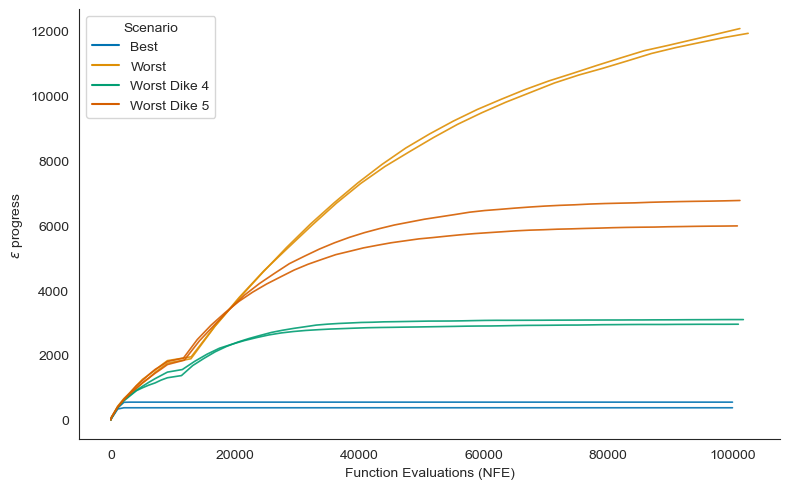

In [7]:
# === Plot epsilon progress ===
def plot_epsilon_progress(convergences, labels):
    sns.set_style("white")
    plt.figure(figsize=(8, 5))

    colors = sns.color_palette("colorblind", len(labels))
    legend_items = []

    for convergence, label, color in zip(convergences, labels, colors):
        legend_items.append((mlines.Line2D([], [], color=color), label))
        for _, group in convergence.groupby("Seed"):
            plt.plot(group.nfe, group.epsilon_progress, lw=1.2, alpha=0.9, color=color)

    plt.ylabel(r'$\epsilon$ progress')
    plt.xlabel("Function Evaluations (NFE)")
    plt.legend(*zip(*legend_items), title="Scenario")
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_epsilon_progress(convergences, labels)


In [25]:
# === Collect and Pad Convergence Results to Align to Max NFE ===
convergences = []
labels = []

max_nfe = 200000  # Desired horizontal extent of the plot

for label in scenarios.keys():
    scenario_convergences = []

    for seed in range(n_seed):
        conv_path = f"./mordm/convergence_results_optimize_{label}_{seed}.csv"
        convergence = pd.read_csv(conv_path)
        convergence["Scenario"] = label
        convergence["Seed"] = seed

        # Pad if needed
        last_nfe = convergence["nfe"].max()
        if last_nfe < max_nfe:
            last_value = convergence.iloc[-1].copy()
            padded_nfes = list(range(last_nfe + 1, max_nfe + 1, 1000))  # padding step = 1000
            pad_rows = pd.DataFrame([{
                "nfe": nfe,
                "epsilon_progress": last_value["epsilon_progress"],
                "Scenario": label,
                "Seed": seed
            } for nfe in padded_nfes])

            convergence = pd.concat([convergence, pad_rows], ignore_index=True)

        scenario_convergences.append(convergence)

    full_conv = pd.concat(scenario_convergences, ignore_index=True)
    convergences.append(full_conv)
    labels.append(label)

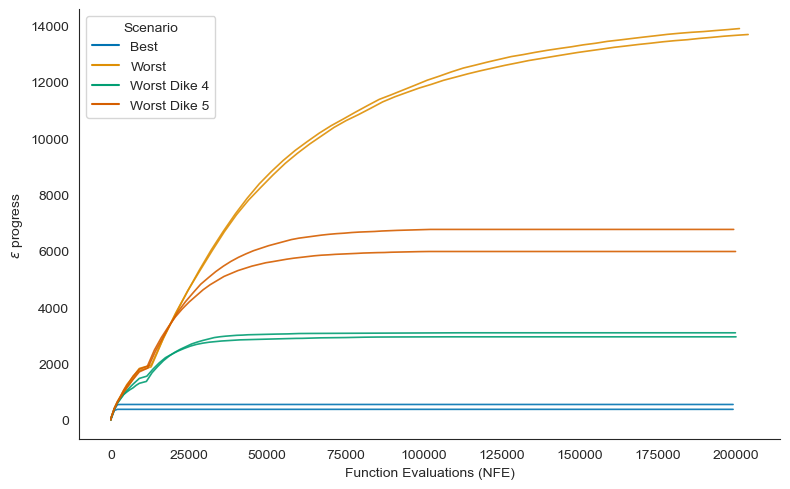

In [26]:
# === Plot epsilon progress ===
def plot_epsilon_progress(convergences, labels):
    sns.set_style("white")
    plt.figure(figsize=(8, 5))

    colors = sns.color_palette("colorblind", len(labels))
    legend_items = []

    for convergence, label, color in zip(convergences, labels, colors):
        legend_items.append((mlines.Line2D([], [], color=color), label))
        for _, group in convergence.groupby("Seed"):
            plt.plot(group.nfe, group.epsilon_progress, lw=1.2, alpha=0.9, color=color)

    plt.ylabel(r'$\epsilon$ progress')
    plt.xlabel("Function Evaluations (NFE)")
    plt.legend(*zip(*legend_items), title="Scenario")
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_epsilon_progress(convergences, labels)


### Step 4: Parellel coordinate plot
After generating optimization results, we apply post-processing filters to reflect stakeholder consensus on outcomes, levers, and constraints. To reduce computational time, constraints are enforced after optimization rather than during. We limit the decision space to solutions with zero deaths and restrict dike heightening to a maximum of 5 decimeters across all dike rings, aligning with local agreements. To visualize trade-offs, we use parallel coordinate plots via the parcoords module, which normalizes data based on predefined axis limits and allows axis inversion to ensure consistent interpretation of objective directions.


In [6]:
# === Parameters ===
folder = "mordm"
n_seed = 2  

stage1_levers = [
    "0_RfR 1", "1_RfR 1", "2_RfR 1", "3_RfR 1", "4_RfR 1",
    "A.1_DikeIncrease 1", "A.2_DikeIncrease 1", "A.3_DikeIncrease 1",
    "A.4_DikeIncrease 1", "A.5_DikeIncrease 1"
]

We try to filter the results based on the dike heightening < 5, and zero death number constraints.

In [11]:
# set constraints for dike hightening
for scenario in scenarios.keys():
    for seed in range(n_seed):
        file_path = os.path.join(folder, f"results_optimize_{scenario}_{seed}.tar.gz")
        archive = ArchiveLogger.load_archives(file_path)
        
        # Combine all DataFrames in the archive into one
        dfs = [df for df in archive.values()]
        if dfs:
            df = pd.concat(dfs, ignore_index=True)
        else:
            continue  # Skip if archive is empty
        
        # filter:  All DikeIncrease 0 <= 5
        for i in range(1, 6):
            for j in range(2):
                dike_col = f"A.{i}_DikeIncrease {j}"
                if dike_col in df.columns:
                    df = df[df[dike_col] <= 5]
        
        # filter: All Expected Number of Deaths < 1
        for i in range(1, 6):
            death_col = f"A.{i}_Expected Number of Deaths"
            if death_col in df.columns:
                df = df[df[death_col] < 1]

        # Save the combined DataFrame to a CSV file
        csv_filename2 = f"./results_DikeConstrains/results_{scenario}_{seed}_DikeConstrains.csv"
        csv_path2 = os.path.join(folder, csv_filename2)
        df.to_csv(csv_path2, index=False)

        print(f"{csv_filename2}: {df.shape[0]} rows, {df.shape[1]} columns")


./results_DikeConstrains/results_Best_0_DikeConstrains.csv: 4 rows, 31 columns
./results_DikeConstrains/results_Best_1_DikeConstrains.csv: 103 rows, 31 columns
./results_DikeConstrains/results_Worst_0_DikeConstrains.csv: 11765 rows, 31 columns
./results_DikeConstrains/results_Worst_1_DikeConstrains.csv: 9313 rows, 31 columns
./results_DikeConstrains/results_Worst Dike 4_0_DikeConstrains.csv: 2078 rows, 31 columns
./results_DikeConstrains/results_Worst Dike 4_1_DikeConstrains.csv: 1042 rows, 31 columns
./results_DikeConstrains/results_Worst Dike 5_0_DikeConstrains.csv: 4659 rows, 31 columns
./results_DikeConstrains/results_Worst Dike 5_1_DikeConstrains.csv: 3842 rows, 31 columns


Plotting for scenario: Best


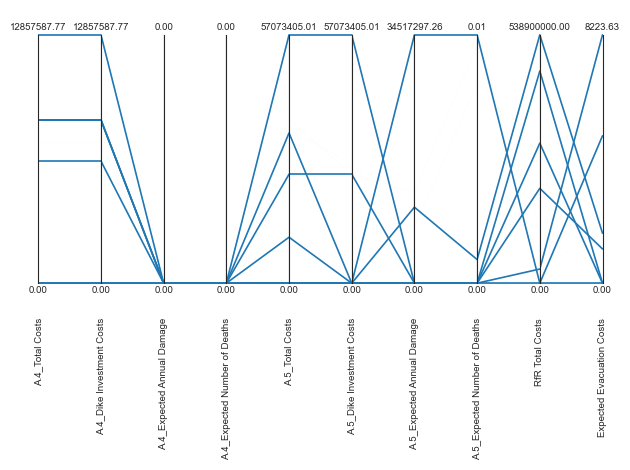

<Figure size 500x500 with 0 Axes>

Plotting for scenario: Worst


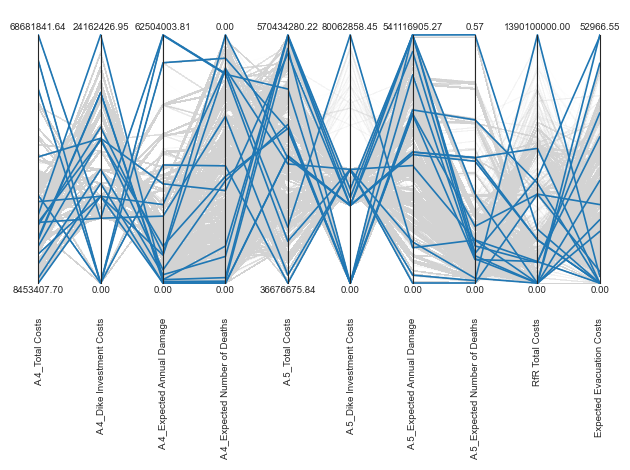

<Figure size 500x500 with 0 Axes>

Plotting for scenario: Worst Dike 4


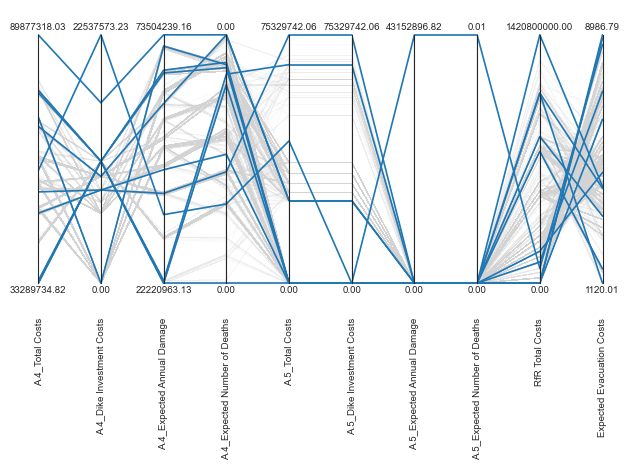

<Figure size 500x500 with 0 Axes>

Plotting for scenario: Worst Dike 5


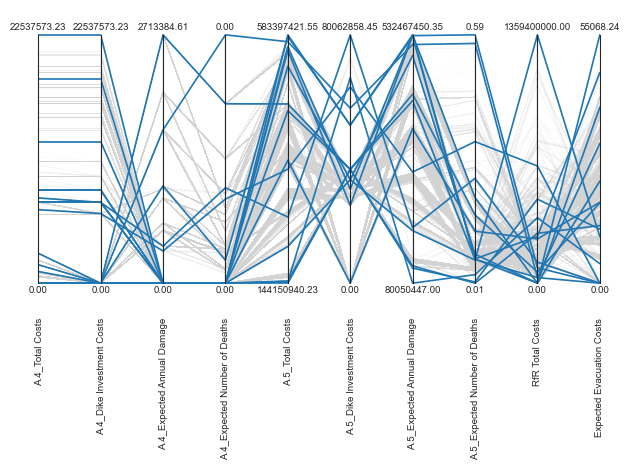

<Figure size 500x500 with 0 Axes>

In [ ]:
# === Loop through scenarios and plot parallel coordinates ===
for label in scenarios.keys():
    print(f"Plotting for scenario: {label}")
    
    # Collect outcomes for all seeds
    all_outcomes = []
    outcome_columns = [o.name for o in model.outcomes]

    for seed in range(n_seed):
        # Load the filtered CSV instead of the archive file
        csv_file = os.path.join(folder, f"./results_DikeConstrains/results_{label}_{seed}_DikeConstrains.csv")
        df = pd.read_csv(csv_file)
        # Select only outcome columns
        df_outcomes = df[outcome_columns]
        all_outcomes.append(df_outcomes)

    if not all_outcomes:
        print(f"No data for scenario {label}")
        continue

    # Combine across seeds
    all_data = pd.concat(all_outcomes, ignore_index=True)

    # Identify lines with extreme values (min or max) on any axis
    indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

    # === Plot ===
    limits = parcoords.get_limits(all_data)
    axes = parcoords.ParallelAxes(limits, rot=90, fontsize=7)

    axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.05)
    axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1.2)

    plt.figure(figsize=(5, 5))
    plt.tight_layout()
    plt.show()

We can also try levers limits in different stages.

In [ ]:
'''
# set constraints for stage 1 levers in Overijssel
for scenario in scenarios.keys():
    for seed in range(n_seed):
        csv_filename1 = f"./results_DikeConstrains/results_{scenario}_{seed}_DikeConstrains.csv"
        csv_path1 = os.path.join(folder, csv_filename1)
        df = pd.read_csv(csv_path1)

        # filter rows: dike A4 and A5 increase in stage 1 == 0
        for i in 4, 5:
            increase_col = f"A.{i}_DikeIncrease 1"  
            if increase_col in df.columns:
                df = df[df[increase_col] == 0]
        
        # filter rows: room for river within Overijssel in stage 1 == 0
        for i in 3, 4:
            rfr_col = f"{i}_RfR 1"  
            if rfr_col in df.columns:
                df = df[df[rfr_col] == 0]

        # Save the combined DataFrame to a CSV file
        csv_filename2 = f"./results_Stage1Constrains/results_{scenario}_{seed}_Stage1Constrains.csv"
        csv_path2 = os.path.join(folder, csv_filename2)
        df.to_csv(csv_path2, index=False)

        print(f"{csv_filename2}: {df.shape[0]} rows, {df.shape[1]} columns")
'''


./results_Stage1Constrains/results_Best_0_Stage1Constrains.csv: 0 rows, 31 columns
./results_Stage1Constrains/results_Best_1_Stage1Constrains.csv: 100 rows, 31 columns
./results_Stage1Constrains/results_Worst_0_Stage1Constrains.csv: 1128 rows, 31 columns
./results_Stage1Constrains/results_Worst_1_Stage1Constrains.csv: 799 rows, 31 columns
./results_Stage1Constrains/results_Worst Dike 4_0_Stage1Constrains.csv: 510 rows, 31 columns
./results_Stage1Constrains/results_Worst Dike 4_1_Stage1Constrains.csv: 91 rows, 31 columns
./results_Stage1Constrains/results_Worst Dike 5_0_Stage1Constrains.csv: 1723 rows, 31 columns
./results_Stage1Constrains/results_Worst Dike 5_1_Stage1Constrains.csv: 1607 rows, 31 columns


### Step 5: Policy selection
In the policy selection step, we aimed to identify a small yet diverse set of promising solutions for robustness analysis. For each of the four scenario-specific optimization results, we first normalized key outcome variables related to damages, investment, and evacuation costs across Dike Rings A.4 and A.5. We then applied KMeans clustering (k=3) to segment the solution space into distinct policy types. Within each cluster, we selected the policy with the lowest aggregated cost, ensuring both diversity and efficiency. This resulted in three top-performing policies per scenario. The final selection includes 12 unique policies across all scenarios, which were saved for the next-stage robustness evaluation.

In [15]:
# Create aggregate columns for each scenario
for label in scenarios.keys():
    # Collect outcomes for all seeds
    all_outcomes = []

    for seed in range(n_seed):
        csv_filename1 = f"./results_DikeConstrains/results_{label}_{seed}_DikeConstrains.csv"
        csv_path1 = os.path.join(folder, csv_filename1)
        df = pd.read_csv(csv_path1)

        df["Overijssel_Deaths"] = df[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
        df["Overijssel_Damages"] = df[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
        df["Overijssel_Investment"] = df[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
        df["Overijssel_RfR_num"] = df[[f"{i}_RfR 0" for i in [3, 4]]].sum(axis=1)

        all_outcomes.append(df)

    # Combine across seeds
    df = pd.concat(all_outcomes, ignore_index=True)
        
    # Save the combined DataFrame to a CSV file
    csv_filename2 = f"./results_Aggregate/results_{label}_Aggregate.csv"
    csv_path2 = os.path.join(folder, csv_filename2) 
    df.to_csv(csv_path2, index=False)
    print(f"{csv_filename2}: {df.shape[0]} rows, {df.shape[1]} columns")

./results_Aggregate/results_Best_Aggregate.csv: 107 rows, 35 columns
./results_Aggregate/results_Worst_Aggregate.csv: 21078 rows, 35 columns
./results_Aggregate/results_Worst Dike 4_Aggregate.csv: 3120 rows, 35 columns
./results_Aggregate/results_Worst Dike 5_Aggregate.csv: 8501 rows, 35 columns


In [ ]:
warnings.filterwarnings("ignore")
# === Select top policies for robustness analysis ===
final_selected = []

for label in scenarios.keys():
    csv_path = os.path.join(folder, f"./results_Aggregate/results_{label}_Aggregate.csv")
    df = pd.read_csv(csv_path)

    # Add scenario label for traceability
    df["Scenario"] = label

    # Ensure diversity by using clustering
    outcome_cols = [
    "A.4_Expected Annual Damage", 
    "A.5_Expected Annual Damage",
    "A.4_Dike Investment Costs", 
    "A.5_Dike Investment Costs",
    "RfR Total Costs", 
    "Expected Evacuation Costs"
    ]
    X = df[outcome_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    df["cluster"] = kmeans.fit_predict(X_scaled)
    df["TotalCost"] = (
        df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"] +
        df["A.4_Dike Investment Costs"] + df["A.5_Dike Investment Costs"] +
        df["RfR Total Costs"] + df["Expected Evacuation Costs"]
    )
    selected = df.groupby("cluster").apply(lambda g: g.sort_values("TotalCost").head(1)).reset_index(drop=True)
    selected.to_csv(f"./mordm/results_Aggregate/selected_policies_from_{label}.csv", index=False)

    final_selected.append(selected)

# Merge all top policies across scenarios
final_df = pd.concat(final_selected, ignore_index=True)

# Save final policy set
final_df.to_csv(f"./mordm/results_Aggregate/final_selected_policies.csv", index=False)
print("Saved final 12 policies for robustness analysis.")


Saved final 12 policies for robustness analysis.
